In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

%matplotlib inline


In [9]:
# base on paper

# RGB2XYZ_Matrix = np.array([[0.5141, 0.3239, 0.1604],
#                            [0.2651, 0.6702, 0.0641],
#                            [0.0241, 0.1228, 0.8444]])

XYZ2LMS_Matrix = np.array([[0.3897, 0.6890, -0.0787],
                           [-0.2298, 1.1834, 0.0464],
                           [0.0000, 0.0000, 1.0000]])

# base on https://docs.opencv.org/3.3.0/de/d25/imgproc_color_conversions.html
RGB2XYZ_Matrix = np.array([[0.412453, 0.357580, 0.180423],
                           [0.212671, 0.715160, 0.072169],
                           [0.019334, 0.119193, 0.950227]])


In [68]:
def readRawImage(url, rows, cols, color=False):
    count = rows*cols*3 if color == True else rows*cols
    shape = (rows, cols, 3) if color == True else (rows, cols)

    fd = open(url, 'rb')
    file = np.fromfile(fd, dtype=np.uint8, count=count)
    fd.close()
    return file.reshape(shape)


def showImage(image, title=""):
    plt.imshow(image, cmap=plt.cm.gray, vmin=0, vmax=255)
    plt.axis("off")
    plt.title(title)


def showImages(datas, cols):
    plt.figure(num=None, figsize=(
        18, 18 * (((len(datas) - 1)//cols) + 1) / cols), dpi=94)
    for index, data in enumerate(datas):
        plt.subplot((len(datas) - 1)//cols + 1, cols, index+1)
        plt.imshow(data["image"], cmap=plt.cm.gray, vmin=0, vmax=255)
        plt.axis("off")
        plt.title(data["title"])


def showImagesHistogram(datas, cols):
    plt.figure(num=None, figsize=(18, 4), dpi=94)
    for index, data in enumerate(datas):
        plt.subplot(len(datas)/cols+1, cols, index+1)
        plt.hist(data["image"].ravel(), bins=256, range=(0, 255))
        plt.title(data["title"])


def showImagesCDF(datas, cols):
    plt.figure(num=None, figsize=(18, 4), dpi=94)
    for index, data in enumerate(datas):
        hist, bin_edges = np.histogram(data["image"], bins=256, range=(0, 255))
        cdf = np.cumsum(hist/256/256)
        plt.subplot(len(datas)/cols+1, cols, index+1)
        plt.plot(cdf)
        plt.title(data["title"] + "\nSuggest threshold: " +
                  str(np.where(cdf > 0.70)[0][0]))


def gammaCorrection(image, gamma=1.0):
    return np.power(image.astype('float32') / float(np.max(image)), 1.0 / gamma)


def RGB2XYZ(image):
    return image.dot(RGB2XYZ_Matrix.T)


def XYZ2RGB(image):
    inverse = np.linalg.inv(RGB2XYZ_Matrix)
    return image.dot(inverse.T)


def XYZ2LMS(image):
    return image.dot(XYZ2LMS_Matrix.T)


def LMS2XYZ(image):
    inverse = np.linalg.inv(XYZ2LMS_Matrix)
    return image.dot(inverse.T)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


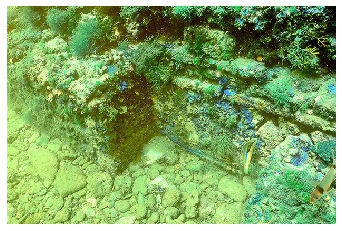

In [70]:
image = cv2.imread('./input/0001.png')
image = gammaCorrection(image)
image = RGB2XYZ(image)
image = XYZ2LMS(image)
image = LMS2XYZ(image)
image = XYZ2RGB(image)

showImage(image)
